In [47]:
import pandas as pd
import numpy as np
from functools import reduce
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
def load_data(path):
    df = pd.read_excel(path)
    title = df.iloc[3]['Unnamed: 0']
    df = df.drop([2, 3])
    data_groups = {}
    current_group = df.iloc[0].values[0]

    for index, value in zip(df.iloc[0].index, df.iloc[0].values):
        if (pd.isna(value)):
            data_groups[current_group].append(index)
        else:
            current_group = value
            data_groups[current_group] = [index]

    data_dfs = []
    index = pd.to_datetime(df['Unnamed: 0'][2:-3], format='mixed')

    for group, cols in zip(list(data_groups.keys())[1:], list(data_groups.values())[1:]):
        data_df = df[cols].copy()
        data_df.columns = data_df.iloc[1].values
        data_df = data_df.drop([0, 1])[:-3]
        data_df = data_df.set_index(index)
        data_df.index = pd.to_datetime(data_df.index)
        data_df.index.names = ['timestamp']
        data_dfs.append((group, data_df))
    
    return title, data_dfs

In [37]:
title, data_dfs = load_data(
    '../data/Svodniy_otchet_po_chasam_intensivnost+skorost_01_01_2024_31_12_2024.xlsx')

In [40]:
data_dfs[0][1].index

DatetimeIndex(['2024-01-01 00:59:59', '2024-01-01 01:59:59',
               '2024-01-01 02:59:59', '2024-01-01 03:59:59',
               '2024-01-01 04:59:59', '2024-01-01 05:59:59',
               '2024-01-01 06:59:59', '2024-01-01 07:59:59',
               '2024-01-01 08:59:59', '2024-01-01 09:59:59',
               ...
               '2024-12-31 14:59:59', '2024-12-31 15:59:59',
               '2024-12-31 16:59:59', '2024-12-31 17:59:59',
               '2024-12-31 18:59:59', '2024-12-31 19:59:59',
               '2024-12-31 20:59:59', '2024-12-31 21:59:59',
               '2024-12-31 22:59:59', '2024-12-31 23:59:59'],
              dtype='datetime64[ns]', name='timestamp', length=8771, freq=None)

In [58]:
def predict(df):
    for col in tqdm(df.columns):
        data = df[col].to_frame().sort_index()
        data['is_nan'] = data[col].isna().astype(int)
        data['group'] = (data['is_nan'].diff() == 1).cumsum()
        data = data.reset_index()
        nan_intervals = data[data['is_nan'] == 1].groupby(
            'group').agg(start=('timestamp', 'first'), end=('timestamp', 'last'))
        data = data.set_index('timestamp')
        data = data.drop(['is_nan', 'group'], axis=1)
        nan_intervals['duration'] = nan_intervals['end'] - nan_intervals['start']
        for interval in tqdm(nan_intervals.itertuples()):
            if (len(interval) == 0):
                continue
            start, end, duration = interval.start, interval.end, interval.duration
            train_end = data[:start].index[-2]
            train_start = (
                train_end - pd.Timedelta(days=train_end.weekday())).normalize()
            train_start = data.iloc[data.index.get_indexer(
                [train_start], method='nearest')[0]].name
            train = data[train_start:train_end]
            seasonal_periods = 24
            if len(train) < seasonal_periods * 2:
                train = pd.concat(
                    [train, data[:train_start][len(train) - (seasonal_periods*2+1):-1]]).sort_index()
                fit = ExponentialSmoothing(
                    train.values,
                    trend=None,
                    seasonal='add',
                    seasonal_periods=seasonal_periods,
                    damped_trend=False,
                ).fit()
                predict_index = data.index[data.index.get_loc(
                    start):data.index.get_loc(end) + 2]
                nan_counts = len(data[start:end])
                df.loc[predict_index,f'{col} - predict'] = fit.forecast(int(nan_counts + 1))

for name, df in data_dfs:
    predict(df)

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00, 17.76it/s]
100%|██████████| 3/3 [00:00<00:00, 20.91it/s]
0it [00:00, ?it/s]/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00, 12.26it/s]
100%|██████████| 3/3 [00:00<00:00, 20.58it/s]
0it [00:00, ?it/s]/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00, 25.22it/s]
100%|██████████| 3/3 [00:00<00:00, 32.16it/s]
0it [00:00, ?it/s]/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00, 24.24it/s]
100%|██████████| 3/3 [00:00<00:00, 31.41it/s]
0it [00:00, ?it/s]/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00, 21.88it/s]
100%|██████████| 3/3 [00:00<00:00, 28.73it/s]
0it [00:00, ?it/s]/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00, 17.22it/s]
100%|██████████| 3/3 [00:00<00:00, 24.60it/s]
0it [00:00, ?it/s]/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00, 18.07it/s]
100%|██████████| 3/3 [00:00<00:00, 21.23it/s]
0it [00:00, ?it/s]/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
/home/nick/transportation/venv/lib/python3.9/site-packages/statsmodels/tsa/holtw

<Axes: xlabel='timestamp'>

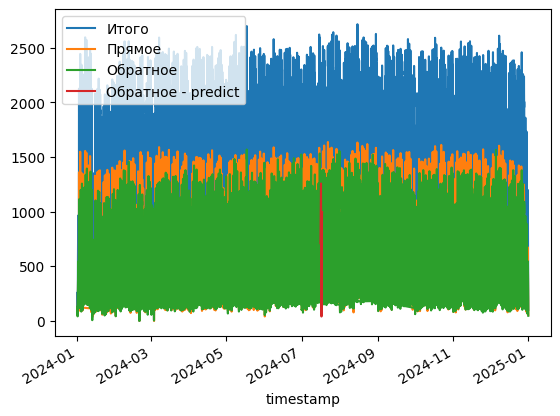

In [60]:
data_dfs[0][1].plot()